## Регуляризация
#### Применить методы линейной регресии, lasso, lasso cv, ridge и ridge cv к данным и вывести MSE и коэффициенты

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import linear_model

In [2]:
#Загрузка файла
#Данные представляют собой информацио о прокате велисипедов. Учитываются факторы:
#Даты, сезона, года, месяца, праздника, дня недели, рабочего/выходного, погоды, температуры, влажности, скорости ветра, 
#количество зарегистрированных и случайных (не зарегистрирванных) пользователей
#cnt - количество арендованных велосипедов
#исследуется зависимость cnt от вышезаданных факторов

cycle_df = pd.read_csv("day.csv", sep=",", parse_dates=['dteday'])

In [3]:
cycle_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
cycle_df.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729


In [5]:
#размер таблицы
cycle_df.shape

(731, 16)

In [6]:
cycle_df.dtypes

instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

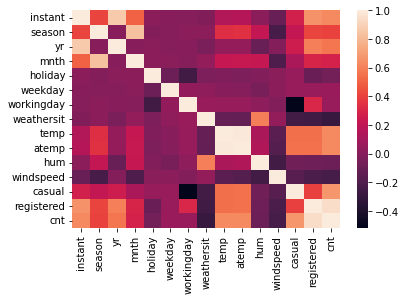

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

#Визуализация данных
sns.heatmap(cycle_df.corr())
plt.rcParams['figure.figsize'] = (12,8)

In [8]:
#зависимость количества арендованных велосипедов от сезона
#1 сезон - весна, 2 - лето, 3 - осень, 4 - зима
#весной в среднем арендовали 2000 велосипедов в день, летом - от 4000 до 8000, осенью примерно столько же, но чуть меньше, зимой -
#в среднем 4000

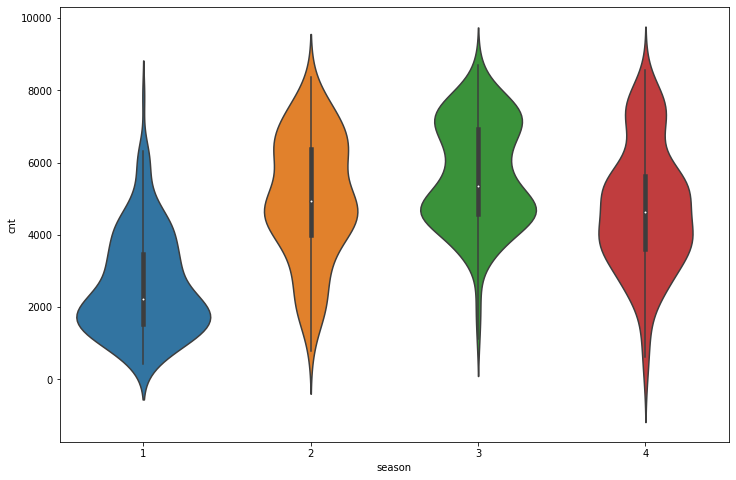

In [9]:
sns.violinplot(x='season', y='cnt', data=cycle_df)
plt.show()

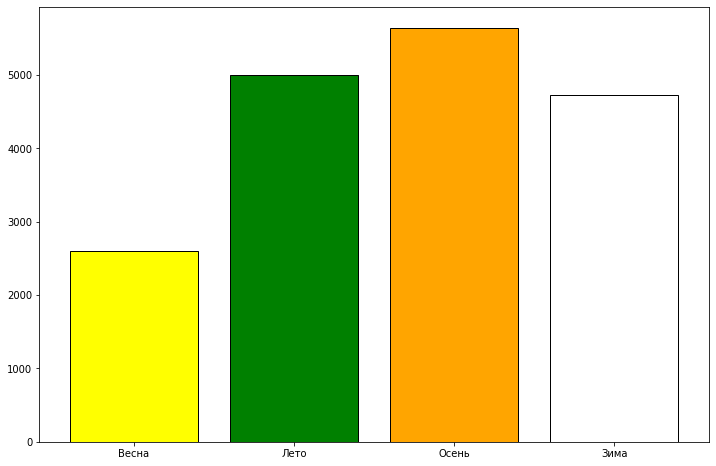

In [10]:
plt.bar(cycle_df.groupby('season').mean().index, cycle_df.groupby('season').mean()['cnt'],
        color=['yellow', 'green','orange', 'white'], edgecolor='black')
plt.xticks(cycle_df.groupby('season').mean().index, ['Весна', 'Лето', 'Осень', 'Зима'])
plt.show()

In [11]:
#Таблица рассеивания количества арендованных велосипедов от всех факторов

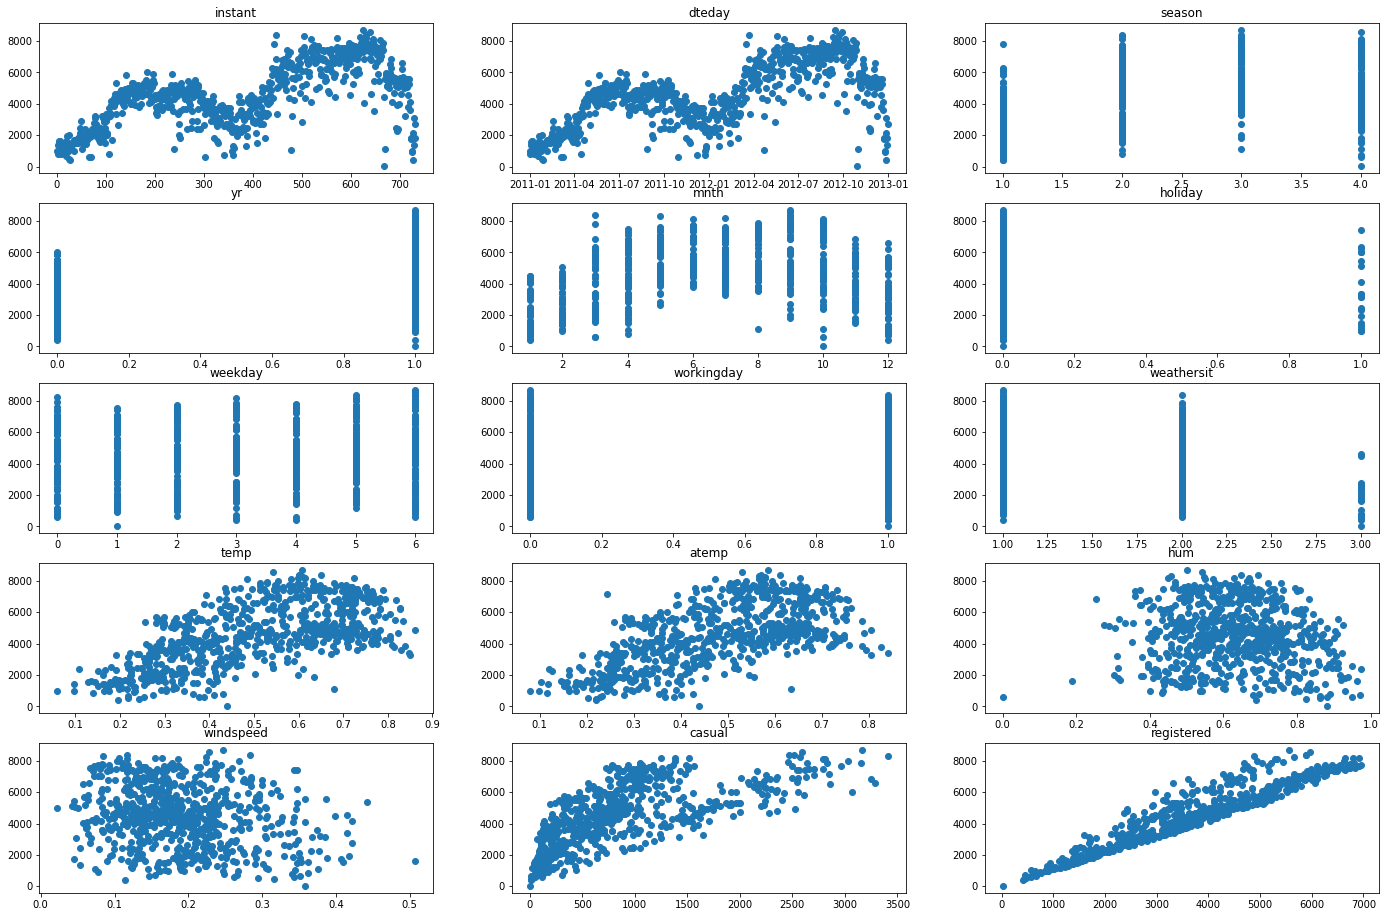

In [12]:
plt.rcParams['figure.figsize'] = (24, 16)
for i, col in enumerate(cycle_df.columns[:-1]):
    plt.subplot(5, 3, i+1)
    plt.scatter(cycle_df[col], cycle_df['cnt'])
    plt.title(col)

In [13]:
#Отдельно рассмотрим таблицу рассеяния количества велосипедов от месяца. В среднем летом-осенью их больше всего арендуют

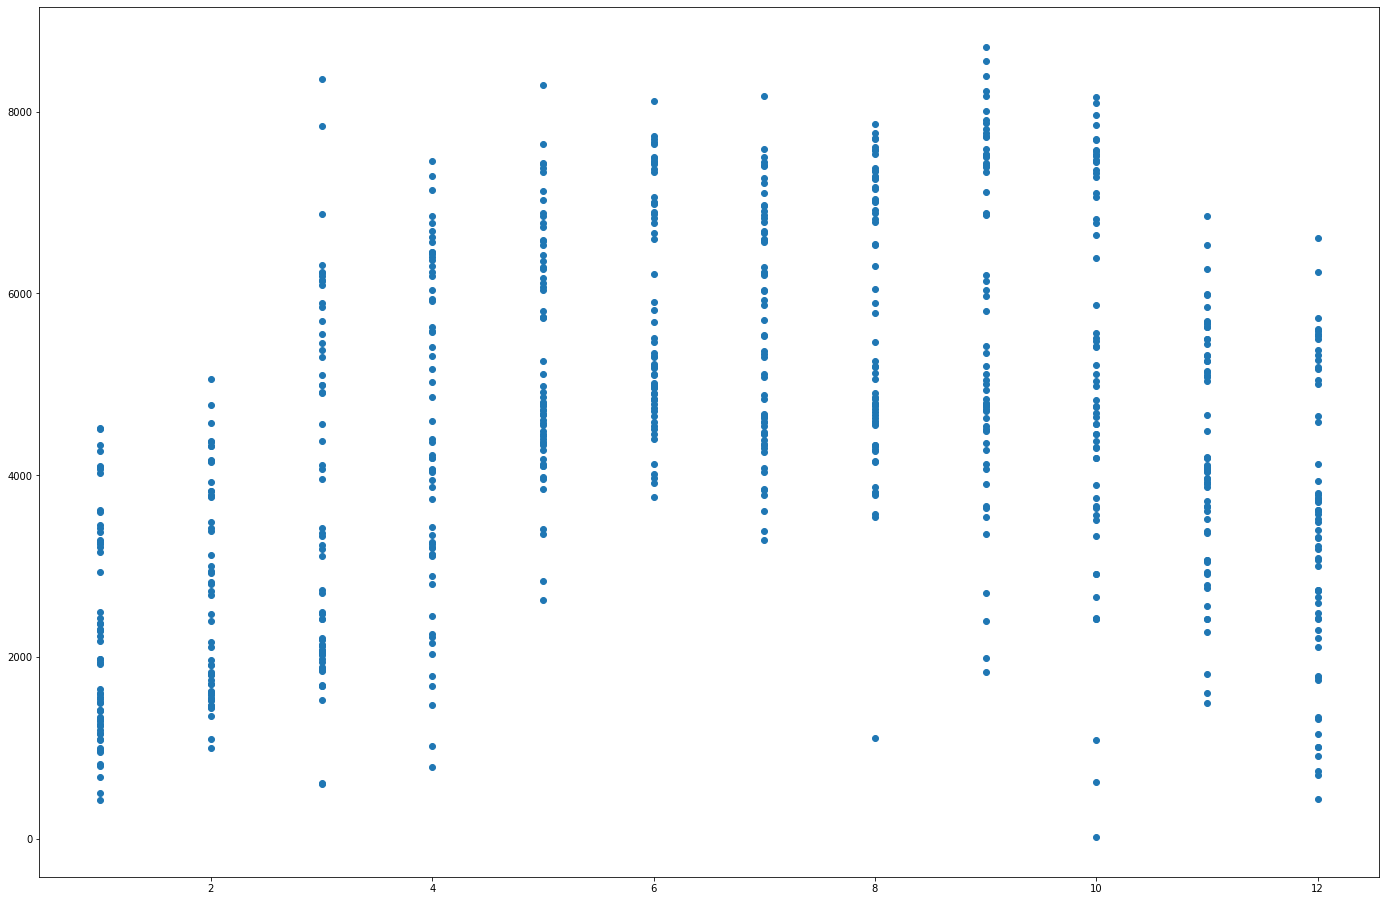

In [14]:
plt.scatter(cycle_df['mnth'], cycle_df['cnt'])
plt.rcParams['figure.figsize'] = (12, 10)

In [15]:
#Зависимость cnt от температуры воздуха (значения делятся на 41)
#вполне очевидно, что когда температура примерно 20-30 градусов (0.5-0.6), велосипеды арендуют более активнее

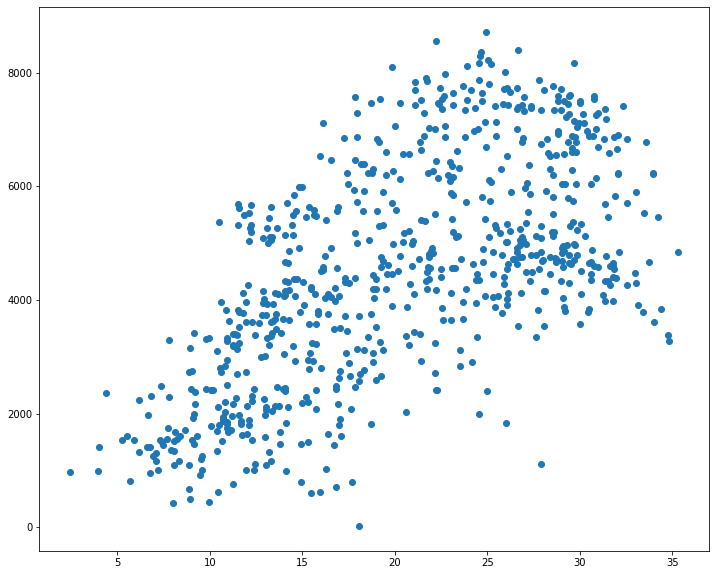

In [16]:
plt.scatter(cycle_df['temp']*41, cycle_df['cnt'])
plt.rcParams['figure.figsize'] = (12, 10)

In [17]:
#Зависимость cnt от погоды
#1 - небольшая облачность
#2 - туман
#3 - легкий снег
#так же видна зависисмость что больше велосипедов арендуют в хорошую погоду. Когда идет снег, велосипеды арендуют достаточно редко

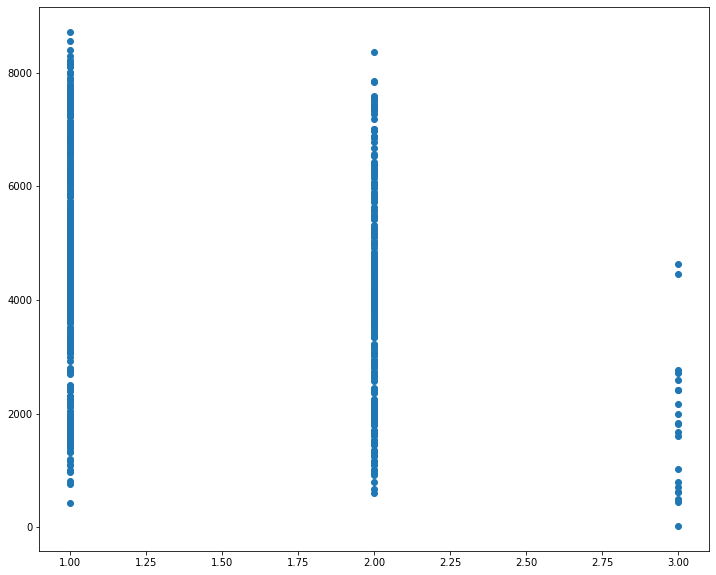

In [18]:
plt.scatter(cycle_df.weathersit, cycle_df['cnt'])
plt.rcParams['figure.figsize'] = (12, 10)

In [19]:
#Замечание
#Визуалзация данных показывает, что некоторые столбцы в таблице не нужны. Однозначно можно убрать номер наблюдения,
#от него ничего не зависит. Дата наблюдения так же не нужна. В таблице уже есть столбцы и с днями недели и с месяцами и с годами
#Сначала исследуем зависимость cnt от всех факторов кроме этих двух, далее посмотрим, что ещё можно сделать для улучшения модели

In [20]:
#Применить методы линейной регресии, lasso, lasso cv, ridge и ridge cv к данным и вывести MSE и коэффициенты
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [21]:
lin_model = LinearRegression()
lasso = Lasso(random_state = 42)
ridge = Ridge(random_state = 42)
lasso_cv = LassoCV(random_state = 42)
ridge_cv = RidgeCV()

In [22]:
cycle_df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [23]:
#Факторы - все параметры в таблице, исключая порядковый номер наблюдения и дату (у нас итак есть день, месяц, год)
X = cycle_df.drop(['cnt', 'instant', 'dteday'], axis=1).values
#Объясняемая переменная - количество арендованных велосипедов
y = cycle_df['cnt'].values

In [24]:
#Делим выборку на обучающую (70%) и контрольную (30%)
train_part_size = int(0.7*X.shape[0])

X_train = X[:train_part_size, :]
X_valid = X[train_part_size:, :]

Y_train = y[:train_part_size]
Y_valid = y[train_part_size:]

In [25]:
#Стандартизация данных необходима, так как данные находятся в разных единицах измерения
#Лучше подходит стандартизация minmax, так как у нас много рваных данных, принимающих значения 0-1
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.fit_transform(X_valid)

In [36]:
#функция, которая применяет выбранный метод к данным и выводит корень MSE, коэффициенты для полученной модели и график,
#показывающий отклонения реальных значений от предсказанных по обущающей выборке
def train_model_report(model, X_train_scaled, Y_train, X_valid_scaled, Y_valid, feature_names):
    model.fit(X_train_scaled, Y_train)
    R = model.score(X_train_scaled, Y_train)
    print('Ошибка: {}'.format(np.sqrt(mean_squared_error(Y_valid, model.predict(X_valid_scaled)))))
    print('Коэффициент детерминации {}'.format(R))
    print(pd.DataFrame(model.coef_, feature_names, columns=['coef']).sort_values(by='coef', ascending=False))
    pred = pd.DataFrame({'pred': model.predict(X_valid_scaled),'real': Y_valid})
    print(pred.plot(figsize=(10,8)))

Ошибка: 278.33189992226056
Коэффициент детерминации 1.0
                    coef
registered  6.017000e+03
casual      3.401000e+03
atemp       5.286438e-12
holiday     3.480771e-12
mnth        1.932676e-12
weathersit  1.833200e-12
yr          1.364242e-12
workingday  9.761081e-13
hum         3.126388e-13
season     -1.306628e-12
windspeed  -2.486900e-12
weekday    -4.411582e-12
temp       -6.906475e-12
AxesSubplot(0.125,0.125;0.775x0.755)


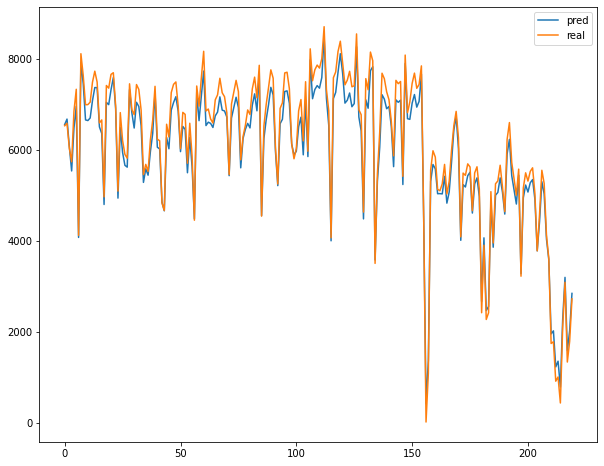

In [37]:
#Линейная регрессия
train_model_report(lin_model, X_train_scaled, Y_train, X_valid_scaled, Y_valid, feature_names = cycle_df.columns[2:-1])

Ошибка: 286.1006887611312
Коэффициент детерминации 0.9999847182512864
                   coef
registered  6001.066421
casual      3378.531092
season         0.000000
yr             0.000000
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
weathersit    -0.000000
temp           0.000000
atemp          0.000000
hum           -0.000000
windspeed     -0.000000
AxesSubplot(0.125,0.125;0.775x0.755)


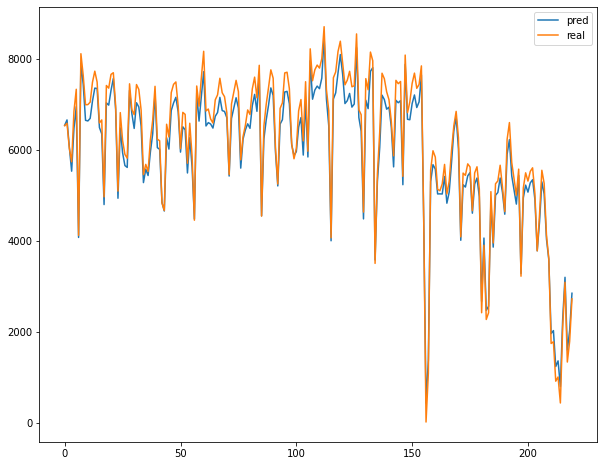

In [38]:
#Применим метод регуляризации Лассо
train_model_report(lasso, X_train_scaled, Y_train, X_valid_scaled, Y_valid, feature_names = cycle_df.columns[2:-1])

Ошибка: 280.6598264829656
Коэффициент детерминации 0.9999986143789958
                   coef
registered  6012.193528
casual      3394.242834
season         0.000000
yr             0.000000
mnth           0.000000
holiday       -0.000000
weekday        0.000000
workingday    -0.000000
weathersit    -0.000000
temp           0.000000
atemp          0.000000
hum           -0.000000
windspeed     -0.000000
AxesSubplot(0.125,0.125;0.775x0.755)


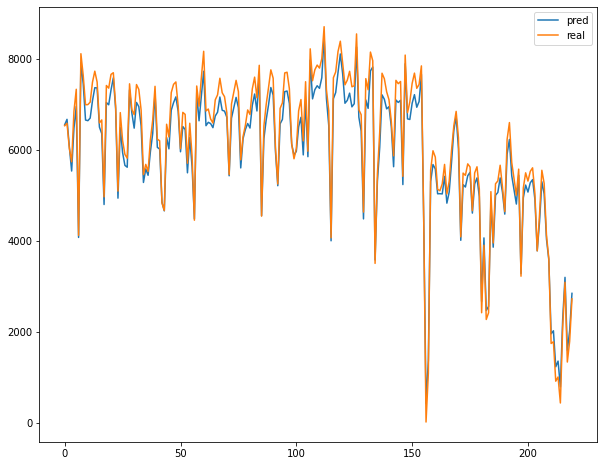

In [39]:
#Лассо CV
train_model_report(lasso_cv, X_train_scaled, Y_train, X_valid_scaled, Y_valid, feature_names = cycle_df.columns[2:-1])

In [40]:
#Альфы для лассо CV


Ошибка: 609.1428133768059
Коэффициент детерминации 0.9956915919616104
                   coef
registered  4952.718942
casual      3203.351495
yr           335.445873
atemp        293.574257
temp         270.930215
season       164.883022
workingday    94.032377
mnth          45.941067
weekday       41.522244
holiday      -40.265818
hum         -108.795133
windspeed   -146.123716
weathersit  -168.141074
AxesSubplot(0.125,0.125;0.775x0.755)


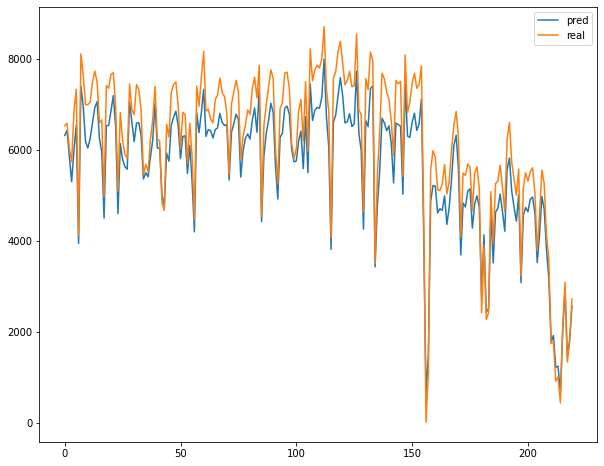

In [41]:
#Метод ridge
train_model_report(ridge, X_train_scaled, Y_train, X_valid_scaled, Y_valid, feature_names = cycle_df.columns[2:-1])

Ошибка: 316.99282408798405
Коэффициент детерминации 0.9999329670613286
                   coef
registered  5879.182497
casual      3384.300377
atemp         48.957007
yr            43.060682
temp          22.293657
season        21.304173
workingday    14.138091
mnth           5.915715
weekday        5.152706
holiday       -4.548954
hum          -15.152517
windspeed    -18.890160
weathersit   -20.924512
AxesSubplot(0.125,0.125;0.775x0.755)


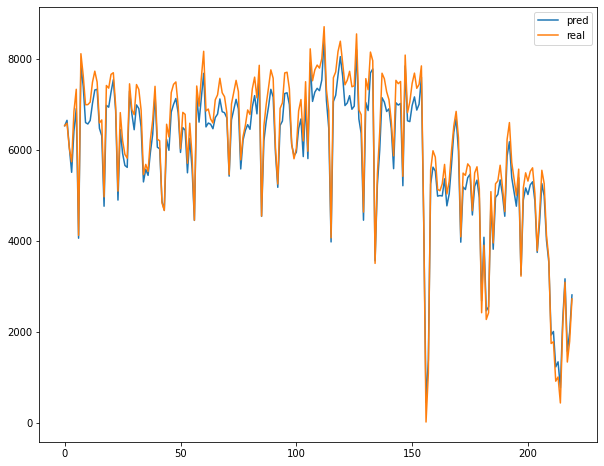

In [42]:
#Метод ridge cv
train_model_report(ridge_cv, X_train_scaled, Y_train, X_valid_scaled, Y_valid, feature_names = cycle_df.columns[2:-1])

## Придумать свой способ обучения модели (удаление незначащих данных, коррелирующих значений и тд)
### Сделать визуализацию и соответствующие выводы

In [ ]:
#Сделаем новую таблицу без...



In [3]:
#построим корреляционную матрицу и попробуем избавиться от незначащих переменных


In [145]:
#Теперь попробуем избавиться от переменных, которые могут быть взаимосвязаны между собой и тем самым
#портить качество модели
